# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import datetime

plt.style.use('ggplot')

# Dataset Import

In [2]:
data_file = 'bmw_pricing_v2.csv'

In [3]:
original_df = pd.read_csv(data_file)

In [4]:
original_df.head()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,BMW,118,140411.0,100.0,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400.0,2018-04-01


In [5]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        4841 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               4842 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4831 non-null   object 
 7   tipo_coche                   4834 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4841 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  4839 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

In [6]:
original_df.isnull().sum()

marca                           2
modelo                          3
km                              2
potencia                        1
fecha_registro                  1
tipo_gasolina                   5
color                          12
tipo_coche                      9
volante_regulable               4
aire_acondicionado              2
camara_trasera                  2
asientos_traseros_plegables     4
elevalunas_electrico            2
bluetooth                       4
gps                             0
alerta_lim_velocidad            2
precio                          6
fecha_venta                     1
dtype: int64

# Preguntas sobre el dataset

In [7]:
# Listado de vehículos agrupados por modelo y tipo de gasolina
original_df.groupby(['modelo', 'tipo_gasolina'])[['precio']].mean()

precio
modelo         tipo_gasolina              
 Active Tourer diesel         19000.000000
114            diesel         10460.000000
               petrol         12700.000000
116            diesel          9757.522124
               petrol          7805.263158
...                                    ...
X6 M           petrol         82400.000000
Z4             petrol          9500.000000
i3             electro        20966.666667
               hybrid_petrol  21266.666667
i8             hybrid_petrol  95200.000000

[109 rows x 1 columns]

In [8]:
# Cantidad de vehículos con potencia superior a 150, convertible y con volante regulable
len(original_df[(original_df['potencia'] > 150) & (original_df['tipo_coche'] == 'convertible') & (original_df['volante_regulable'] == True)])

9

In [9]:
# Fecha de registro superior a la fecha de venta?

serie_incremento_fechas = (pd.to_datetime(original_df['fecha_venta']) - pd.to_datetime(original_df['fecha_registro'])).dt.days
valores_negativos = serie_incremento_fechas[serie_incremento_fechas < 0].index
display(original_df.loc[valores_negativos, :])

# Precio medio de estos coches

print(f'Precio medio de estos coches: {original_df.loc[valores_negativos, "precio"].mean():.2f}')
print(f'Precio medio global: {original_df["precio"].mean():.2f}')

# Parece que son más baratos que la media global

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
42,BMW,330,142483.0,180.0,2012-01-01,diesel,blue,convertible,True,True,False,False,True,False,True,True,15800.0,2007-08-01
100,BMW,320,342768.0,135.0,2011-12-01,diesel,black,coupe,False,True,False,False,True,False,True,False,8200.0,2010-04-01
180,BMW,320,181052.0,120.0,2014-10-01,diesel,black,estate,False,True,False,False,False,False,True,True,11500.0,2009-04-01
256,BMW,316,201102.0,85.0,2013-12-01,diesel,black,estate,True,False,False,False,False,False,True,False,8800.0,2008-06-01


Precio medio de estos coches: 11075.00
Precio medio global: 15831.92


In [10]:
# Precio medio de los vehículos con aire acondicionad
round(original_df[original_df['aire_acondicionado'] == True]['precio'].mean(), 2)

# Parece que son un poco más caros respecto la media global

16998.12

In [11]:
# Precio medio por color
original_df.groupby(by = ['color'])[['precio']].agg(['mean', 'count']).sort_values(by = ('precio', 'mean'), ascending = False)

# El color verde es significativamente más barato que el resto, y no se tiene una sola muestra (no parece ser un outlier)
# El color naranja es el más caro (hay pocas muestras) seguido del blanco.

precio      
                mean count
color                     
orange  18866.666667     6
white   17314.365672   536
red     16568.627451    51
black   16178.479460  1631
beige   15817.073171    41
grey    15619.914530  1170
brown   15367.741935   341
blue    15137.784091   704
silver  14826.299694   327
green    7200.000000    18

# Generación del modelo predictivo

## EDA + Data cleaning

### Target

In [12]:
# Se trabaja con el format_df para empezar a manipular el dataset
format_df = original_df.copy()

In [13]:
# El target es el precio. Es una variable numérica, así que es correcta tal y como está
target = 'precio'

In [14]:
# Se dropean los valores nulos del target, ya que són muy pocos (6 de 4843)
format_df.dropna(subset = [target], inplace = True)

In [15]:
# Precio medio para tenerlo como referencia
format_df[target].mean()

15831.920611949556

<AxesSubplot:>

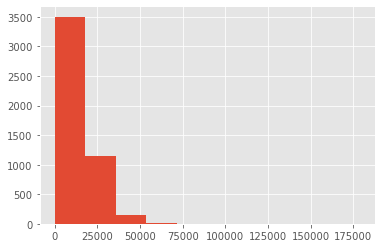

In [16]:
# Distribución del precio. Se ve claramente una distribución right-skewed, por lo que se aplicará una función logarítmica
format_df[target].hist()

In [17]:
# Solo 32 coches tienen un precio superior a 50.000
len(format_df[format_df[target] > 50000])

32

### Columna Marca

In [18]:
# Como se trata de un dataset de BMW, se intuye que todos los coches serán de la misma marca
format_df['marca'].unique()

array(['BMW', nan], dtype=object)

In [19]:
# Se borra la columna porque, aunque tenga algunos nulos, todos los coches son de la misma marca
format_df.drop(columns = 'marca', inplace = True)

### Columnas de fecha

In [20]:
# Se detecta que las siguientes columnas contienen fechas:
glob_list_date = [column for column in format_df.columns if 'fecha' in column]

In [21]:
# Nulos de las columnas de fecha:
format_df[glob_list_date].isnull().sum()

fecha_registro    1
fecha_venta       1
dtype: int64

In [22]:
format_df[format_df[glob_list_date[0]].isnull()]

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
198,318,158853.0,100.0,NaN,diesel,black,estate,True,False,False,False,False,False,True,False,10900.0,2018-06-01


In [23]:
format_df[format_df[glob_list_date[1]].isnull()]

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
594,525,269290.0,120.0,2005-06-01,diesel,silver,estate,True,False,True,False,False,False,True,True,4200.0,NaN


Para rellenar los nulos, se decide calcular el tiempo medio entre la fecha de venta y la fecha de registro e imputar el valor que falta acorde al número calculado

In [24]:
# Se pasan las columnas a datetime
for column in glob_list_date:
    format_df[column] = pd.to_datetime(format_df[column])

In [25]:
# Se analiza la muestra del tiempo entre registro y venta
date_series = (format_df['fecha_venta'] - format_df['fecha_registro']).dt.days

In [26]:
# Parece que hay algún valor nulo y algún outlier
date_series.describe()

count     4835.000000
mean      1980.819235
std        932.754943
min      -2009.000000
25%       1489.000000
50%       1765.000000
75%       2130.000000
max      10258.000000
dtype: float64

<AxesSubplot:>

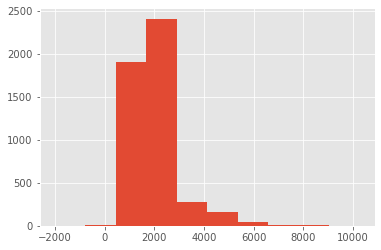

In [27]:
date_series.hist()

In [28]:
# Porcentaje de valores con fecha de registro posterior a la venta muy bajo
len(date_series[date_series < 0]) / len(date_series) * 100

0.08269588587967748

In [29]:
# Porcentaje de valores con fecha de venta superior a 8000 días a la fecha de registro
len(date_series[date_series > 8000]) / len(date_series) * 100

0.08269588587967748

In [30]:
# Se decide hacer la media con el 99% de los datos centrales
cuantil_bajo = np.nanquantile(date_series, 0.005)
cuantil_alto = np.nanquantile(date_series, 0.995)

In [31]:
# Se calcula la media y se pasa a valor entero redondeado
media_date_series = int(round(date_series[(date_series > cuantil_bajo) & (date_series < cuantil_alto)].mean(), 0))

In [32]:
media_date_series

1963

In [33]:
# Se rellenan los valores nulos
format_df['fecha_venta'].fillna(format_df['fecha_registro'] + datetime.timedelta(days = media_date_series), inplace = True)

In [34]:
format_df['fecha_registro'].fillna(format_df['fecha_venta'] - datetime.timedelta(days = media_date_series), inplace = True)

Como el modelo no acepta columnas datetime, se extrae toda la informació que se considera útil de las fechas en formato número. Concretamente:

In [35]:
# Se calcula el tiempo entre venta y registro, en días
format_df['dias_venta_registro'] = (format_df['fecha_venta'] - format_df['fecha_registro']).dt.days

In [36]:
# En la exploración inicial se detecta que los días de la fecha siempre son el primero de mes.
# La excepción es debido valor nulo imputado a posteriori
format_df['fecha_registro'].dt.day.value_counts()

1     4836
15       1
Name: fecha_registro, dtype: int64

In [37]:
format_df['fecha_venta'].dt.day.value_counts()

1     4836
16       1
Name: fecha_venta, dtype: int64

In [38]:
# Se extrae el año y el mes. El día no se extrae debido a que no hay varianza
for column in glob_list_date:
    format_df[column + '_año'] = format_df[column].dt.year
    format_df[column + '_mes'] = format_df[column].dt.month

In [39]:
format_df.head()

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,...,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta,dias_venta_registro,fecha_registro_año,fecha_registro_mes,fecha_venta_año,fecha_venta_mes
0,118,140411.0,100.0,2012-02-01,diesel,black,convertible,True,True,False,...,True,True,False,11300.0,2018-01-01,2161,2012,2,2018,1
1,M4,13929.0,317.0,2016-04-01,petrol,grey,convertible,True,True,False,...,True,True,True,69700.0,2018-02-01,671,2016,4,2018,2
2,320,183297.0,120.0,2012-04-01,diesel,white,convertible,False,False,False,...,False,True,False,10200.0,2018-02-01,2132,2012,4,2018,2
3,420,128035.0,135.0,2014-07-01,diesel,red,convertible,True,True,False,...,True,True,True,25100.0,2018-02-01,1311,2014,7,2018,2
4,425,97097.0,160.0,2014-12-01,diesel,silver,convertible,True,True,False,...,True,True,True,33400.0,2018-04-01,1217,2014,12,2018,4


In [40]:
# Se eliminan las columnas datetime al haber sido ya tratadas
format_df.drop(columns = glob_list_date, inplace = True)

### Columnas numéricas

#### EDA

In [41]:
# Lista de variables numéricas
glob_list_num = list(format_df.describe().drop(columns = target).columns)

In [42]:
# Se podría plantear la eliminiación de la variablefecha_venta_año por poca varianza
format_df[glob_list_num].describe().T

,count,mean,std,min,25%,50%,75%,max
km,4835.0,140966.371251,60220.786757,-64.0,102870.0,141068.0,175243.5,1000376.0
potencia,4836.0,128.995037,39.011169,0.0,100.0,120.0,135.0,423.0
dias_venta_registro,4837.0,1980.811867,932.562116,-2009.0,1489.0,1765.0,2130.0,10258.0
fecha_registro_año,4837.0,2012.466405,2.528326,1990.0,2012.0,2013.0,2014.0,2017.0
fecha_registro_mes,4837.0,6.129212,3.316570,1.0,3.0,6.0,9.0,12.0
fecha_venta_año,4837.0,2017.990490,0.298037,2007.0,2018.0,2018.0,2018.0,2018.0
fecha_venta_mes,4837.0,4.930535,2.158651,1.0,3.0,5.0,7.0,10.0


In [43]:
# Función para plottear la relación entre las variables numéricas
def round_up(num, div):
    return num // div + (num % div > 0)

def relacion_num_target(df, num_vars, target):
    plt.subplots(figsize = (20, 30))
    for i, column in enumerate(num_vars):
        plt.subplot(round_up(len(num_vars), 2), 2, i + 1)
        sns.scatterplot(data = df[[column, target]], x = column, y = target)
        plt.title(f'Relación entre {column} y {target}')
    plt.show()

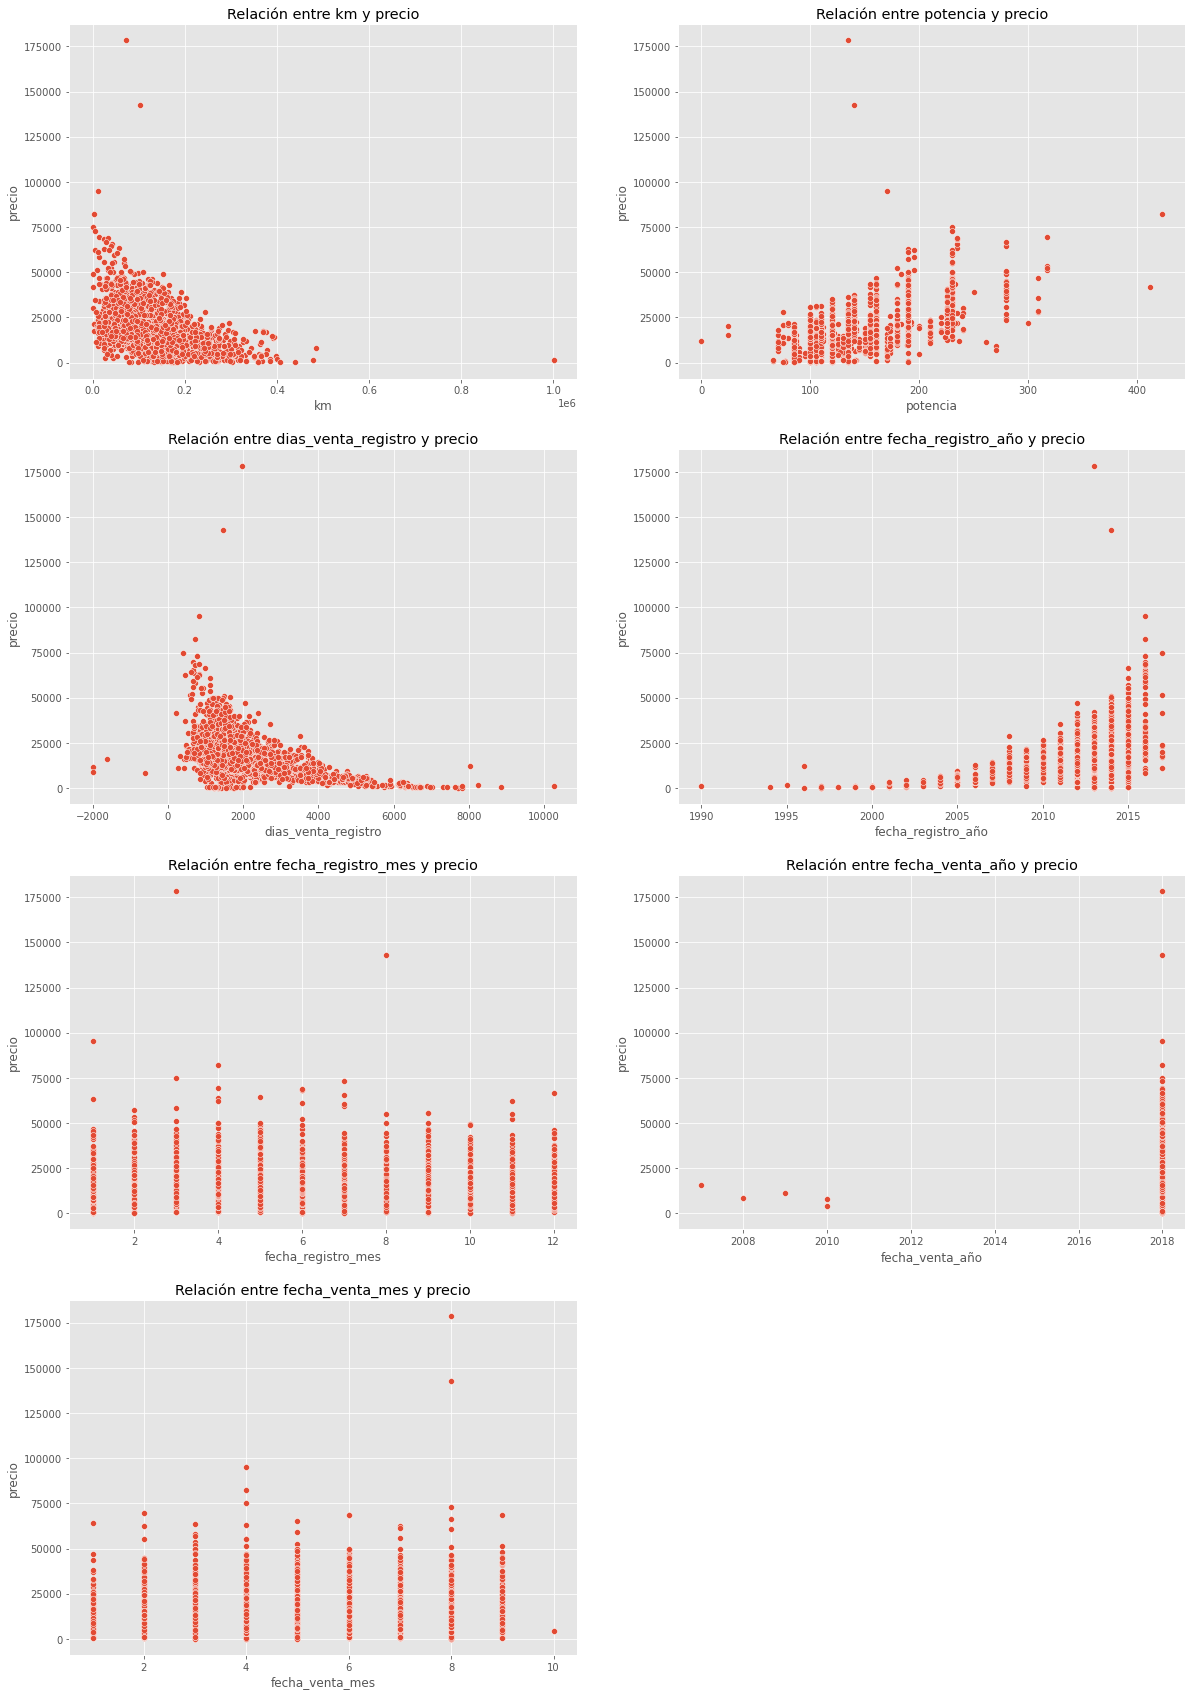

In [44]:
# Variables que parecen ser buenas predictoras: km, potencia, dias entre venta y registro y año de registro
relacion_num_target(format_df, glob_list_num, target)

In [45]:
# Con la matriz de correlación podemos determinar lo dicho anteriormente:
format_df[glob_list_num + [target]].corr().style.background_gradient('coolwarm')

,km,potencia,dias_venta_registro,fecha_registro_año,fecha_registro_mes,fecha_venta_año,fecha_venta_mes,precio
km,1.000000,-0.050539,0.499631,-0.507520,-0.017290,-0.041713,0.000856,-0.410189
potencia,-0.050539,1.000000,-0.083753,0.082588,-0.000535,-0.000289,-0.028643,0.639254
dias_venta_registro,0.499631,-0.083753,1.000000,-0.984611,-0.041546,0.101339,0.123570,-0.440964
fecha_registro_año,-0.507520,0.082588,-0.984611,1.000000,-0.070540,0.015767,-0.054683,0.450314
fecha_registro_mes,-0.017290,-0.000535,-0.041546,-0.070540,1.000000,-0.017375,-0.016422,-0.016037
fecha_venta_año,-0.041713,-0.000289,0.101339,0.015767,-0.017375,1.000000,-0.022240,0.019843
fecha_venta_mes,0.000856,-0.028643,0.123570,-0.054683,-0.016422,-0.022240,1.000000,0.012214
precio,-0.410189,0.639254,-0.440964,0.450314,-0.016037,0.019843,0.012214,1.000000


En primer lugar, se confirma con la matriz de correlación que las variables más relacionadas con el target son:

- km
- potencia
- dias_venta_registro
- fecha_registro_años

Además, se puede visualizar la relación entre atributos numéricos. Destaca lo siguiente:

- km está relacionado con dias_venta_registro. Tiene sentido ya que se intuye que el coche estará más usado si han pasado más días entre los días de venta y registro.
- La variable dias_venta_registro está altamente correlacionada con fecha_registro_año. Esta última se eliminará en la parte de limpieza de datos

Adicionalmente, en caso de aplicar un modelo de regresión lineal, probablemente ayudaría a aplicar el logaritmo a dias_venta_registro, ya que parece tener cierta relación no lineal. Tambíen se podrían transformar los nulos a 0, ya que son solo 4 valores y no tiene mucho sentido que sea negativo

#### Data cleaning

In [46]:
# Se elimina la columna de fecha_registro_año. La de fecha_venta_año se mantiene
format_df.drop(columns = 'fecha_registro_año', inplace = True)

In [47]:
# Se recalcula la lista de numéricas
glob_list_num = list(format_df.describe().drop(columns = target).columns)

In [48]:
# Se tienen valores nulos en km y potencia
format_df[glob_list_num].isnull().sum()

km                     2
potencia               1
dias_venta_registro    0
fecha_registro_mes     0
fecha_venta_año        0
fecha_venta_mes        0
dtype: int64

In [49]:
# Se asigna el kilometraje del coche en función de los días entre venta y registro mediante un modelo lineal
# Anteriormente ya se ha visto que están correlacionadas
train_sample_km = format_df[['dias_venta_registro', 'km']].dropna()
model_km = LinearRegression()
model_km.fit(np.array(train_sample_km['dias_venta_registro']).reshape(-1, 1), np.array(train_sample_km['km']))
null_values = format_df[format_df['km'].isnull()].index
format_df.loc[null_values, 'km'] = model_km.predict(np.array(format_df.loc[null_values, 'dias_venta_registro']).reshape(-1, 1))

In [50]:
# Se asigna la potencia restante del coche a partir del modelo y el tipo de gasolina
format_df[format_df['potencia'].isnull()]

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,dias_venta_registro,fecha_registro_mes,fecha_venta_año,fecha_venta_mes
181,525,106054.0,NaN,diesel,black,estate,False,True,False,False,False,False,True,True,18700.0,1400,5,2018,3


In [51]:
diesel_525 = format_df.groupby(['modelo', 'tipo_gasolina']).get_group(('525', 'diesel'))

In [52]:
diesel_525['potencia'].describe()

count    180.000000
mean     150.805556
std       15.661966
min       85.000000
25%      150.000000
50%      155.000000
75%      160.000000
max      160.000000
Name: potencia, dtype: float64

In [53]:
# Se decide asignar la potencia media de este subgrupo
format_df['potencia'].fillna(round(diesel_525['potencia'].mean(), 0), inplace = True)

In [54]:
format_df.head()

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,dias_venta_registro,fecha_registro_mes,fecha_venta_año,fecha_venta_mes
0,118,140411.0,100.0,diesel,black,convertible,True,True,False,False,True,True,True,False,11300.0,2161,2,2018,1
1,M4,13929.0,317.0,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700.0,671,4,2018,2
2,320,183297.0,120.0,diesel,white,convertible,False,False,False,False,True,False,True,False,10200.0,2132,4,2018,2
3,420,128035.0,135.0,diesel,red,convertible,True,True,False,False,True,True,True,True,25100.0,1311,7,2018,2
4,425,97097.0,160.0,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400.0,1217,12,2018,4


In [55]:
format_df[glob_list_num].isnull().sum()

km                     0
potencia               0
dias_venta_registro    0
fecha_registro_mes     0
fecha_venta_año        0
fecha_venta_mes        0
dtype: int64

### Columnas categóricas

#### EDA

In [56]:
glob_list_bool = [column for column in format_df.columns if format_df[column].nunique() == 2]

In [57]:
# Proporción de cada variable booleana. Pocos coches sin bluetooth. El resto no está muy desbalanceado
bool_prop_list = []
for column in glob_list_bool:
    bool_prop_list.append(format_df[column].value_counts(normalize = True))
pd.DataFrame(bool_prop_list)

,True,False
volante_regulable,0.549969,0.450031
aire_acondicionado,0.792554,0.207446
camara_trasera,0.201448,0.798552
asientos_traseros_plegables,0.199048,0.800952
elevalunas_electrico,0.460393,0.539607
bluetooth,0.241465,0.758535
gps,0.931983,0.068017
alerta_lim_velocidad,0.540848,0.459152


In [58]:
def violinplot_bool(df, bool_vars, target):
    plt.subplots(figsize = (20, 30))
    for i, column in enumerate(bool_vars):
        plt.subplot(round_up(len(bool_vars), 2), 2, i + 1)
        sns.violinplot(data = df[[column, target]], x = column, y = target)
        plt.title(f'Relación entre {column} y {target}')
    plt.show()

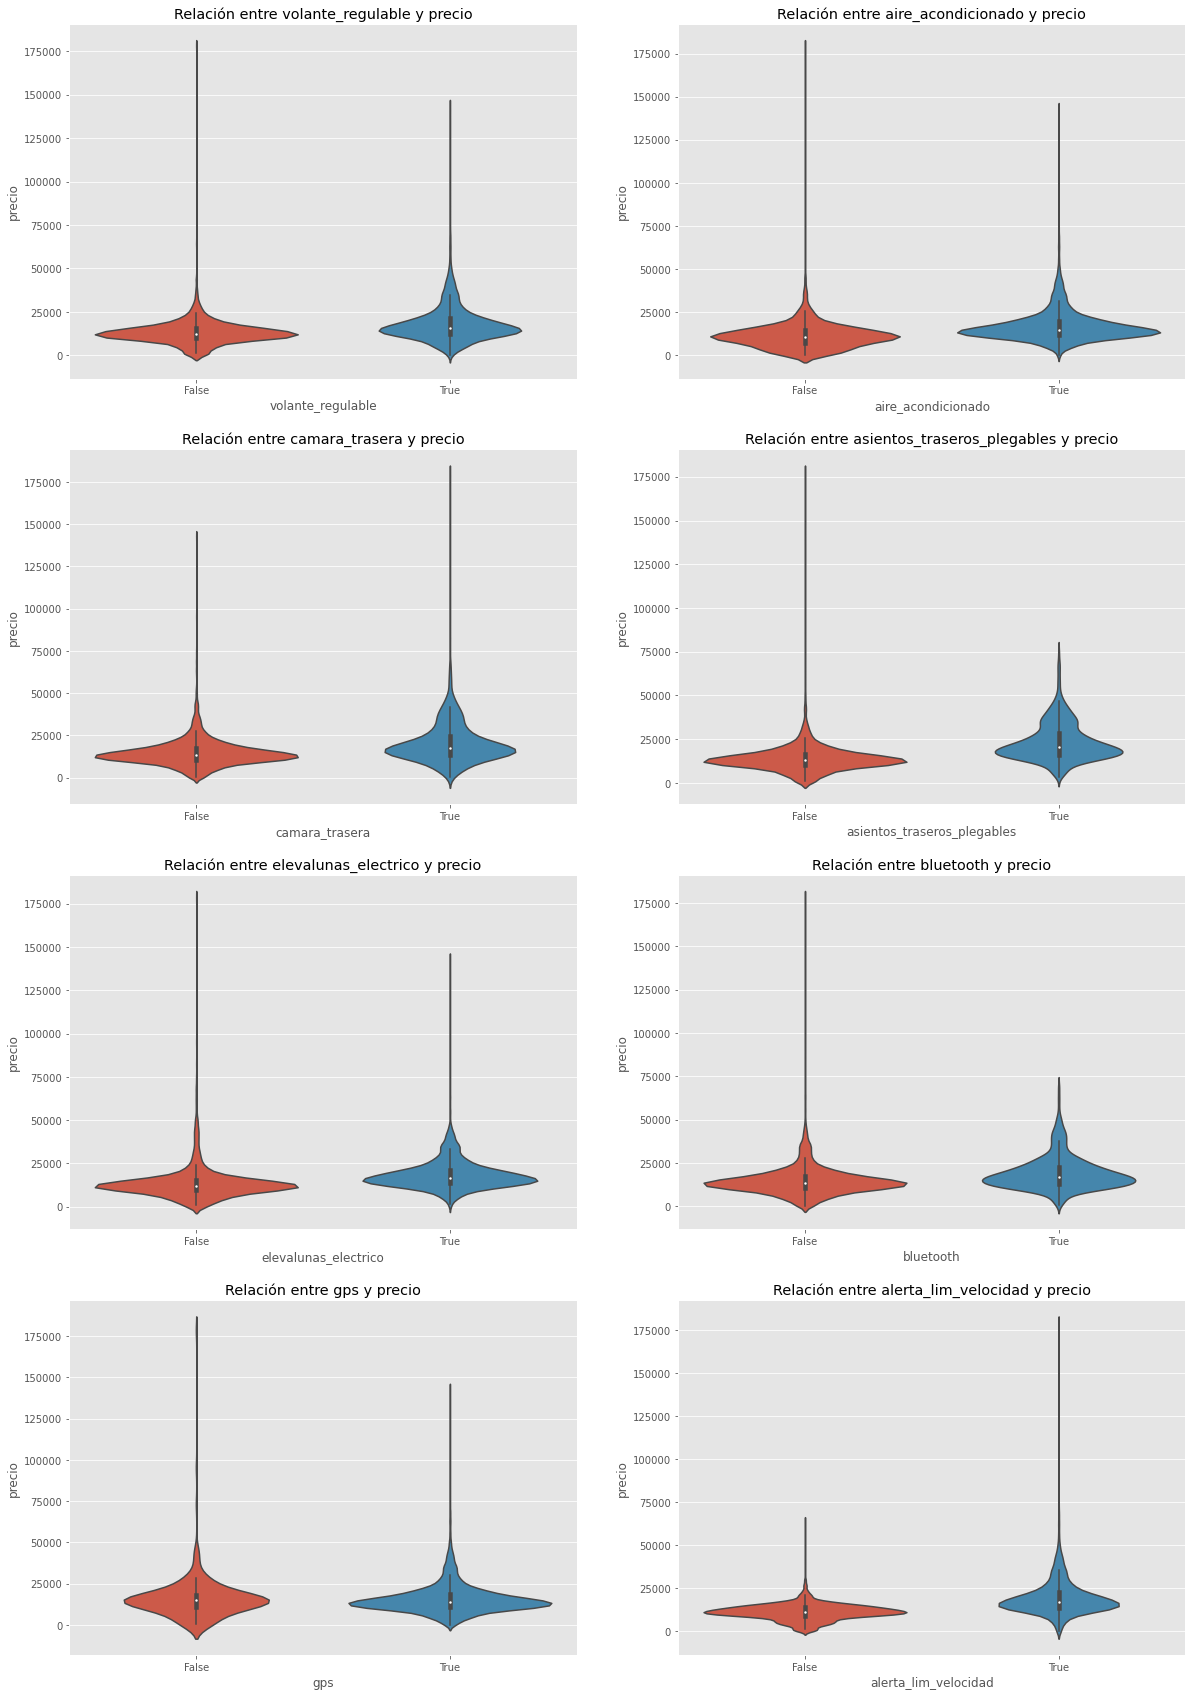

In [59]:
violinplot_bool(format_df, glob_list_bool, target)

En todos los casos excepto en la variable gps, si el atributo está en True, es decir, si se dispone de este accesorio, el precio parece ser un poco superior, lo cual es totalmente lógico (a más extras, más caro!).

Los que parecen tener más impacto son:

- camara_trasera
- asientos_traseros_plegables
- aleta_lim_velocidad

En el caso del gps, puede ser que no se vea mucha diferencia entre tenerlo o no porque se disponen de pocas muestras que no lo tengan.

In [60]:
# Resto de variables categóricas
glob_list_cat = list(set(format_df.describe(include = 'O').columns) - set(glob_list_bool))

In [61]:
# Para las categóricas con pocas categorías, se visualizan datos interesantes
def report_cat(df, cat_var, target):
    '''
    Se hace un report de la variable categórica con información interesante, 
    los nulos se agrupan bajo la etiqueta Other
    '''
    df_copy = df[cat_var + [target]].copy()

    for column in cat_var:

        if df_copy[column].nunique() > 11:
            less_freq_cat = df_copy[column].value_counts().iloc[10:].index
            df_copy[column] = df_copy[column].apply(lambda x: 'others' if x in less_freq_cat else x)

        report_df = df_copy[[column, target]].pivot_table(values = target, index = column, aggfunc = [len, np.mean,])
        report_df.columns = [x[0] + ' ' + x[1] for x in report_df.columns]

        report_df[f'proportion {target}'] = report_df[f'len {target}'] / report_df[f'len {target}'].sum() * 100 
        report_df = report_df[[f'len {target}', f'proportion {target}', f'mean {target}']]
        
        display(report_df.round(2).sort_values(by = f'mean {target}', ascending = False))

In [62]:
report_cat(format_df, glob_list_cat, target)

,len precio,proportion precio,mean precio
modelo,,,
X5,231.0,4.78,30570.13
others,1009.0,20.87,20753.72
530,157.0,3.25,19826.11
X3,438.0,9.06,18175.80
520,632.0,13.07,15713.29
525,184.0,3.81,15363.04
X1,274.0,5.67,12691.97
320,750.0,15.52,12173.07
318,567.0,11.73,10982.19


,len precio,proportion precio,mean precio
tipo_coche,,,
coupe,103.0,2.13,22169.90
suv,1057.0,21.89,21500.47
convertible,47.0,0.97,17136.17
sedan,1167.0,24.17,16021.94
van,43.0,0.89,14323.26
hatchback,699.0,14.48,13289.41
estate,1599.0,33.12,13126.33
subcompact,113.0,2.34,9687.61


,len precio,proportion precio,mean precio
tipo_gasolina,,,
hybrid_petrol,8.0,0.17,37575.00
electro,3.0,0.06,20966.67
diesel,4625.0,95.72,15859.26
petrol,191.0,3.95,14398.43
Diesel,5.0,0.10,13960.00


,len precio,proportion precio,mean precio
color,,,
orange,6.0,0.12,18866.67
white,536.0,11.11,17314.37
red,51.0,1.06,16568.63
black,1631.0,33.80,16178.48
beige,41.0,0.85,15817.07
grey,1170.0,24.25,15619.91
brown,341.0,7.07,15367.74
blue,704.0,14.59,15137.78
silver,327.0,6.78,14826.30


In [63]:
# Se detecta que existen coches diesel con la primera letra en mayúscula, hecho que ensucia la muestra. Para arreglarlo:
format_df['tipo_gasolina'] = format_df['tipo_gasolina'].str.lower()

In [64]:
format_df['tipo_gasolina'].unique()

array(['diesel', 'petrol', nan, 'hybrid_petrol', 'electro'], dtype=object)

In [65]:
# Análisis básico de cada etiqueta de cada atributo categórico
report_cat(format_df, glob_list_cat, target)

,len precio,proportion precio,mean precio
modelo,,,
X5,231.0,4.78,30570.13
others,1009.0,20.87,20753.72
530,157.0,3.25,19826.11
X3,438.0,9.06,18175.80
520,632.0,13.07,15713.29
525,184.0,3.81,15363.04
X1,274.0,5.67,12691.97
320,750.0,15.52,12173.07
318,567.0,11.73,10982.19


,len precio,proportion precio,mean precio
tipo_coche,,,
coupe,103.0,2.13,22169.90
suv,1057.0,21.89,21500.47
convertible,47.0,0.97,17136.17
sedan,1167.0,24.17,16021.94
van,43.0,0.89,14323.26
hatchback,699.0,14.48,13289.41
estate,1599.0,33.12,13126.33
subcompact,113.0,2.34,9687.61


,len precio,proportion precio,mean precio
tipo_gasolina,,,
hybrid_petrol,8.0,0.17,37575.00
electro,3.0,0.06,20966.67
diesel,4630.0,95.82,15857.21
petrol,191.0,3.95,14398.43


,len precio,proportion precio,mean precio
color,,,
orange,6.0,0.12,18866.67
white,536.0,11.11,17314.37
red,51.0,1.06,16568.63
black,1631.0,33.80,16178.48
beige,41.0,0.85,15817.07
grey,1170.0,24.25,15619.91
brown,341.0,7.07,15367.74
blue,704.0,14.59,15137.78
silver,327.0,6.78,14826.30


In [66]:
def boxenplot_cat(df, cat_var, target):
    plt.subplots(figsize = (20, 30))
    for i, column in enumerate(cat_var):
        df_copy = df[[column, target]].copy()
        if df_copy[column].nunique() > 11:
            less_freq_cat = df_copy[column].value_counts().iloc[10:].index
            df_copy[column] = df_copy[column].apply(lambda x: 'others' if x in less_freq_cat else x)
        plt.subplot(len(cat_var), 1, i + 1)
        sns.boxenplot(data = df_copy, x = column, y = target)
        plt.title(f'Relación entre {column} y {target}')
    plt.show()

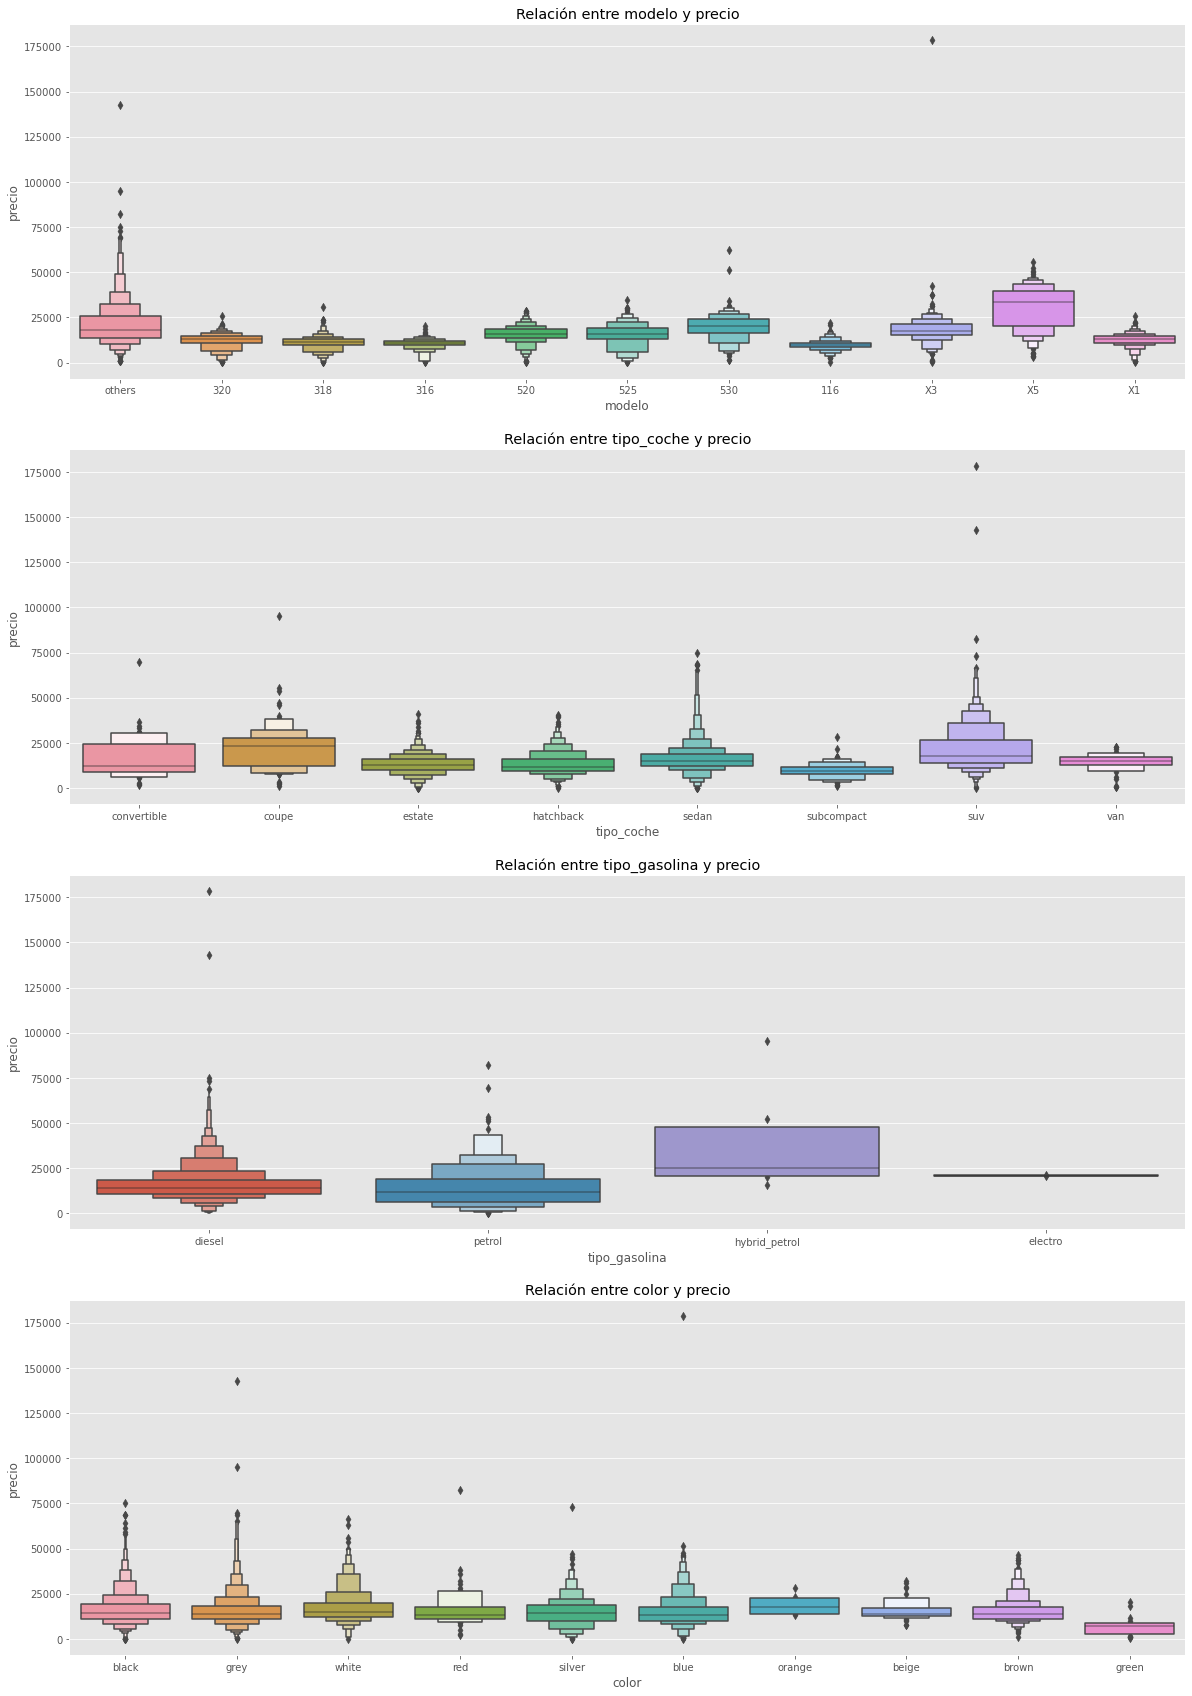

In [67]:
boxenplot_cat(format_df, glob_list_cat, target)

- tipo_coche: existen bastantes muestras de todos los tipos de coche, sin ninguna etiqueta con claramente pocas observaciones. Parece que los SUVs son el tipo de coche más caro, y los sedan también tiene observaciones con precio alto (parte alta del boxenplot muy estirada). En el casod de los coupé hay más variabilidad (tiene un boxenplot muy cuadrado) pero también tiene un precio bastante elevado (etiqueta con la media del precio más elevada). Finalmente, la etiqueta con un precio más bajo es el sub-compact.

- color: hay una etiqueta con un precio claramente más bajo que el resto: es el color verde. El resto de colores no parecen tener diferencias muy claras: si bien es verdad el color naranja tiene una media bastante elevada, tiene muy pocas observaciones (6). El color blanco podría tener una tendencia más a la alza a nivel de precio, pero tampoco es muy claro.

- tipo_gasolina: hay claramente muchísimas muestras de diesel. Parece que los coches híbridos tienen un precio más elevado.

- modelo: el modelo que claramente es el más caro es el x5. Por contra, el 116 parece ser el más barato. La categoría others parece tenir una gran variabilidad, lo que es comprensible ya que abarca varios modelos distintos.

#### Data cleaning

In [68]:
# En primer lugar, se intuye una posible correlación entre modelo y tipo_coche
pd.crosstab(format_df['modelo'], format_df['tipo_coche']).head(20)

tipo_coche,convertible,coupe,estate,hatchback,sedan,subcompact,suv,van
modelo,,,,,,,,
Active Tourer,0,0,0,0,0,0,0,1
114,0,0,0,10,0,5,0,0
116,0,0,2,272,3,79,0,0
118,3,2,0,108,7,21,0,0
120,5,2,0,23,3,3,0,0
123,0,0,0,1,0,1,0,0
125,0,0,0,5,0,0,0,0
135,1,1,0,2,0,0,0,0
214 Gran Tourer,0,0,0,0,0,0,0,1


En primer lugar se rellenan los nulos de la columna de modelo. Para hacerlo se seguirá el procedimiento siguiente:
- Se localiza qué tipo de coche es el coche con el nulo
- Se extraen los modelos que entre su recuento de tipo de coches normalizado, el tipo de coche del nulo sea superior al 30%
- Una vez se obtienen los modelos, se extrae la potencia media de cada modelo
- El modelo que rellenará el nulo será el que tenga una diferencia menor entre la potencia media y la potencia del nulo

In [75]:
def imputar_nulos_modelo(df):

    idx_nulos = df[df['modelo'].isnull()].index

    for idx in idx_nulos:
        tipo_coche = df.loc[idx, 'tipo_coche']
        modelos_validos = format_df[format_df['tipo_coche'] == tipo_coche]['modelo'].dropna().unique()

        lista_modelos = []

        for modelo in modelos_validos:
            counts = format_df[format_df['modelo'] == modelo]['tipo_coche'].value_counts(normalize = True)

            if counts[tipo_coche] > 0.3:
                lista_modelos.append(modelo)

        serie_potencias_medias = df[df['modelo'].isin(lista_modelos)].groupby('modelo')['potencia'].mean()
        serie_potencias_diff = abs(serie_potencias_medias - df.loc[idx, 'potencia'])
        modelo_final = serie_potencias_diff.idxmin()
        df.loc[idx, 'modelo'] = modelo_final
        print(f'Modelo imputado a la fila {idx}: {modelo_final}')

In [76]:
imputar_nulos_modelo(format_df)

Modelo imputado a la fila 173: 518
Modelo imputado a la fila 4766: X1
Modelo imputado a la fila 4802: 218 Gran Tourer


In [77]:
format_df['modelo'].isnull().sum()

0